In [1]:
import os
import sys
from pathlib import Path

sys.path.append("..")

import albumentations as albu
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import numpy as np

# 画像の読み出し

In [2]:
fig_dir_pth = os.path.join("..", "assets", "jupyter_fig")

# Path オブジェクトの作成
p = Path(fig_dir_pth)
fig_pth_list = list(p.glob("*.png"))

print(fig_pth_list)

[PosixPath('../assets/jupyter_fig/binary.png'), PosixPath('../assets/jupyter_fig/page.png')]


外部ライブラリのなかには `Path` を受け付けないものもあります。軽く調べたところ、`numpy.loadtxt(Path_obj)` や `pandas.read_csv(Path_obj)` は正常にファイルを開けましたが、`cv2.imread(Path_obj)` はエラーになりました。
Pathオブジェクトを通常の文字列に変換するには、`Path.as_posix` 関数を使います。あるいは、`str(Path)` のようにキャストしてもよいです。

参考: [Pythonでフォルダ内のファイルリストを取得する](https://qiita.com/amowwee/items/e63b3610ea750f7dba1b)

In [3]:
org_fig = [cv2.imread(pth.as_posix()) for pth in fig_pth_list]
# print(org_fig)

In [4]:
def DataGenerator(root_dir: str, exp: str = ".png", transform=None):
    # Path オブジェクトの作成
    p = Path(fig_dir_pth)
    fig_pth_list = list(p.glob(f"*{exp}"))
    i = 0
    fig = []
    while True:
        org_fig = cv2.imread(fig_pth_list[i].as_posix())
        fig.append(org_fig)

        if transform:
            transformed_img = transform(image = org_fig)
            fig.append(transformed_img["image"])
        else:
            zero = np.zeros((org_fig.shape[0], org_fig.shape[1]))
            fig.append(zero)
        yield fig

In [5]:
def visualizeGenerator(gen):
    # Iterate the generator to get image and mask batches
    img = next(gen)

    fig = plt.figure(figsize=(10, 5))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.1)
    
    for i in range(2):
        ax = plt.Subplot(fig, outerGrid[i])
        ax.imshow(img[i])
        # ax.axis('off')
        fig.add_subplot(ax)
    plt.show()

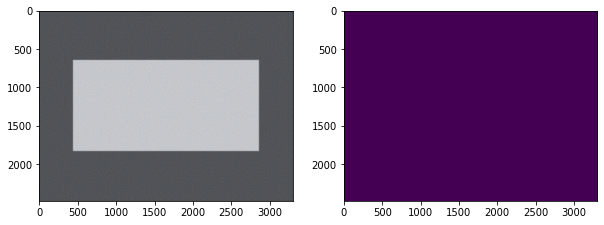

In [6]:
img_gen = DataGenerator(root_dir=fig_dir_pth)
visualizeGenerator(img_gen)

# 2. Albmentations を用いたデータ拡張

## 2.1.1 Affine 変換（スケール変換）
参考: [albumentations.augmentations.geometric.transforms.Affine](https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.Affine)

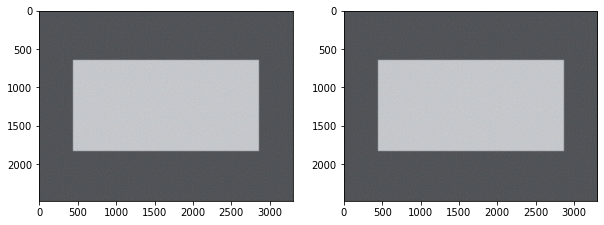

In [7]:
transform = albu.Compose([albu.Affine(scale=0.5)], p=1)
img_gen = DataGenerator(root_dir=fig_dir_pth, transform=transform)
visualizeGenerator(img_gen)

## 2.1.2 Affine 変換（平行移動）
参考: [albumentations.augmentations.geometric.transforms.Affine](https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.Affine)

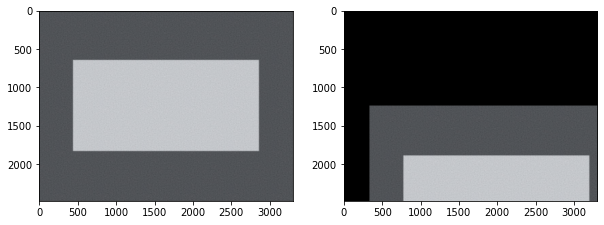

In [8]:
transform = albu.Compose([albu.Affine(translate_percent={"x":0.1, "y":0.5}, p=1)])
img_gen = DataGenerator(root_dir=fig_dir_pth, transform=transform)
visualizeGenerator(img_gen)

## 2.1.3 Affine 変換（回転）
参考: [albumentations.augmentations.geometric.transforms.Affine](https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.Affine)

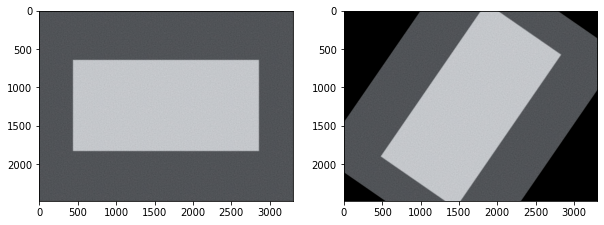

In [9]:
transform = albu.Compose([albu.Affine(rotate=(-90, 90), p=1)])  # -90 ~ 90 の範囲でサンプリング（毎回回転角度が異なる）
img_gen = DataGenerator(root_dir=fig_dir_pth, transform=transform)
visualizeGenerator(img_gen)

## 2.1.4 Affine 変換（せん断）
参考: [albumentations.augmentations.geometric.transforms.Affine](https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.Affine)

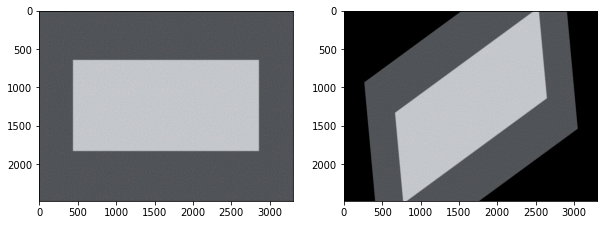

In [10]:
transform = albu.Compose([albu.Affine(shear=(-90, 90), p=1)])  # -90 ~ 90 の範囲でサンプリング（毎回回転角度が異なる）
img_gen = DataGenerator(root_dir=fig_dir_pth, transform=transform)
visualizeGenerator(img_gen)

## 2.2. CenterCrop
参考: [albumentations.augmentations.crops.transforms.CenterCrop](https://albumentations.ai/docs/api_reference/augmentations/crops/transforms/#albumentations.augmentations.crops.transforms.CenterCrop)

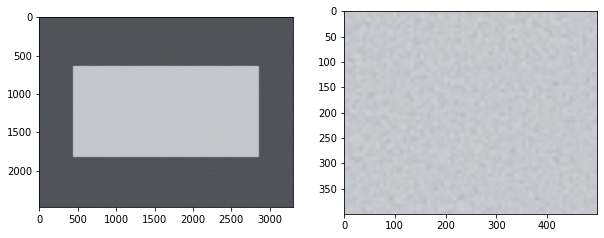

In [11]:
transform = albu.Compose([albu.CenterCrop(height=400, width=500, p=1)])  # -90 ~ 90 の範囲でサンプリング（毎回回転角度が異なる）
img_gen = DataGenerator(root_dir=fig_dir_pth, transform=transform)
visualizeGenerator(img_gen)

## 2.3. Crop
参考: [albumentations.augmentations.crops.transforms.Crop](https://albumentations.ai/docs/api_reference/augmentations/crops/transforms/#albumentations.augmentations.crops.transforms.Crop)

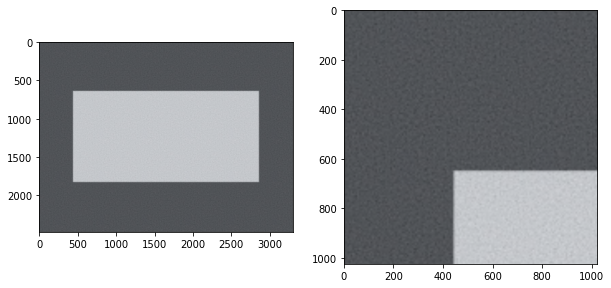

In [12]:
transform = albu.Compose([albu.Crop(x_min=0, y_min=0, x_max=1024, y_max=1024, p=1)])  # -90 ~ 90 の範囲でサンプリング（毎回回転角度が異なる）
img_gen = DataGenerator(root_dir=fig_dir_pth, transform=transform)
visualizeGenerator(img_gen)

# OpenCV の特徴点マッチング

In [13]:
img_gen = DataGenerator(root_dir=fig_dir_pth, transform=transform)
img = next(img_gen)

In [14]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
detector = cv2.AKAZE_create()
(target_kp, target_des) = detector.

SyntaxError: invalid syntax (1049161556.py, line 3)

In [ ]:
# 抽出精度を高めるため、グレースケール変換を行う

# 画像の一致率の計算

# Optuna を用いた一致率の最小化